In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics as mtx

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import cm
%matplotlib inline

In [2]:
dir_kidney = '/data/kidney/'
meta = pd.read_csv(f'{dir_kidney}/tables/splits-2019-03-24.csv', index_col=0)

slide_ids = {}
for kk in meta.set.unique():
    slide_ids[kk] = meta[meta.set==kk].index.tolist()

In [3]:
slide_ids['test']

['70bb3032750d09e7549928c0dbf79afc30d7cb68',
 'a1fc67fbb21f43b9e8904b9b46bd94f83493b37a',
 'c886827fe8c10b4699a0f1616331e36b46a05617',
 'dfe3ee768f72bddd289c7d5bb88b15cbb89be7e6',
 'f7f931a5cf3185a385e9aa34e6e9a566fc88000c',
 'c7234341626ed41fc7be77217cfd5ca3bc712b0d',
 '8900c7cede2699f23357346a5f12cd8087538032',
 '1006231850a8e1b2f2529d37de7d0bdc56609d1b',
 '93aca82fd3c77234f58c9d71b7d726834fc6528c',
 '9bbfc43088eed7ef710f5260eac5d77dcb160a28']

In [4]:
meta.loc['c886827fe8c10b4699a0f1616331e36b46a05617']

lymphoid              21
norm                 158
set                 test
pos_fraction    0.117318
Name: c886827fe8c10b4699a0f1616331e36b46a05617, dtype: object

In [5]:
import rpy2
%load_ext rpy2.ipython

In [6]:
set_ = 'test'
# set_ = 'val'
tabs_segm = {}
for kk in slide_ids[set_]:
    fn_segm = f'./results/vgg16_unet/{kk}-segmentation.csv'
#     fn_pred = f'{dirname}/{kk}-predictions.csv'
#     print(fn_segm)
    try:
        tabs_segm[kk] = pd.read_csv(fn_segm, index_col=0)
#         tabs_segm[kk]['logit'] = pd.read_csv(fn_pred, index_col=0).mean(1).tolist()
#         tabs_classif[kk]['slide_id'] = kk
    except Exception as ee:
        print(ee)
        
tabs_segm = pd.concat(tabs_segm, sort=False).rename(columns={'prediction':'segm_score'})
tabs_segm.index = tabs_segm.index.get_level_values(0)
tabs_segm.index.name = 'slide_id'
tabs_segm.reset_index(inplace=True)
tabs_segm['slide_id_6'] = tabs_segm['slide_id'].str[:6]
tabs_segm['slide_id_6'].value_counts()

100623    7489
8900c7    5321
f7f931    5249
c72343    4871
93aca8    3285
c88682    2920
70bb30    2842
9bbfc4    2706
dfe3ee    2125
a1fc67    2112
Name: slide_id_6, dtype: int64

In [7]:
tabs_segm_iid = {}
for kk, vv in tabs_segm.groupby('slide_id'):
    y_offset = (vv.y%1024).value_counts().index[0]
    x_offset = (vv.x%1024).value_counts().index[0]
    print(kk, x_offset, y_offset)
    tabs_segm_iid[kk] = vv[((vv.x%1024) == x_offset) & ((vv.y%1024) == y_offset)]
    
tabs_segm_iid = pd.concat(tabs_segm_iid.values()).reset_index()

1006231850a8e1b2f2529d37de7d0bdc56609d1b 929 80
70bb3032750d09e7549928c0dbf79afc30d7cb68 632 306
8900c7cede2699f23357346a5f12cd8087538032 996 486
93aca82fd3c77234f58c9d71b7d726834fc6528c 377 460
9bbfc43088eed7ef710f5260eac5d77dcb160a28 182 376
a1fc67fbb21f43b9e8904b9b46bd94f83493b37a 869 649
c7234341626ed41fc7be77217cfd5ca3bc712b0d 774 417
c886827fe8c10b4699a0f1616331e36b46a05617 901 26
dfe3ee768f72bddd289c7d5bb88b15cbb89be7e6 796 922
f7f931a5cf3185a385e9aa34e6e9a566fc88000c 273 231


segm_test_scatter.png


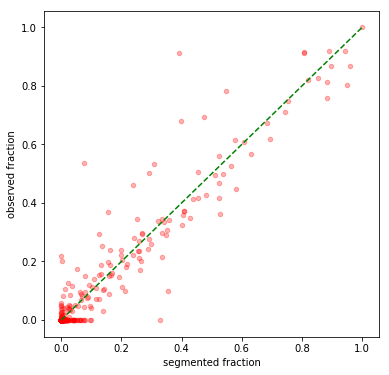

In [8]:
fig, ax = plt.subplots(1, figsize=(6,6))
tabs_segm_iid.plot(x='segm_score', y='observed', alpha=0.3,
               kind='scatter', c='r', ax=ax)
ax.plot([0,1],[0,1], 'g--')

ax.set_ylabel('observed fraction')
ax.set_xlabel('segmented fraction')

fnfig = f'segm_{set_}_scatter.png'
print(fnfig)
fig.savefig(fnfig, dpi=300)
pass

In [9]:
from scipy import stats

/home/exx/.conda/envs/digipath/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


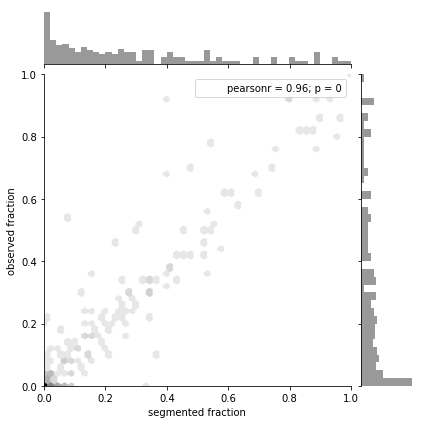

In [10]:
jpl = sns.jointplot(x='segm_score', y='observed', 
                    data=tabs_segm_iid, #alpha=0.3,
                    kind="hex", bins='log',
                    stat_func=stats.pearsonr,
                    cmap='gray_r',
                    marginal_kws=dict(color='k'),
                   )
jpl.ax_marg_x.set_yscale('log')
jpl.ax_marg_y.set_xscale('log')
ax = jpl.ax_joint
ax.set_ylabel('observed fraction')
ax.set_xlabel('segmented fraction')
jpl.fig.savefig('segm_{set_}_hex_logdensity.png', dpi=300)

In [11]:
# tabs_segm[tabs_segm['slide_id_6'] == 'c88682'].plot(x='segm_score', y='observed', alpha=0.3,
#                kind='scatter', c='r')
# # tabs_segm = pd.concat(tabs_segm)
# # tabs_segm[~tabs_segm['logit'].isnull()].shape
# # fn_meta = '/data/kidney/src/sung/kidney/results/a1fc67fbb21f43b9e8904b9b46bd94f83493b37a-segmentation.csv'
# # pd.read_csv(fn_meta, index_col=0)

In [12]:
# pd.read_csv(fn_pred, index_col=0)#.mean(1).shape

In [13]:
tabs_segm.slide_id_6.unique()

array(['100623', '70bb30', '8900c7', '93aca8', '9bbfc4', 'a1fc67',
       'c72343', 'c88682', 'dfe3ee', 'f7f931'], dtype=object)

In [14]:
tabs_segm.groupby('slide_id_6')['observed'].sum()

slide_id_6
100623      0.000000
70bb30    130.136612
8900c7      0.000000
93aca8      0.000000
9bbfc4      0.000000
a1fc67     36.074173
c72343      0.000000
c88682    116.984238
dfe3ee     82.694763
f7f931    453.425171
Name: observed, dtype: float64

In [15]:
pearson_rs = {}
for kk,vv in tabs_segm_iid.groupby('slide_id_6'):
    pearson_rs[kk] = vv[['segm_score', 'observed']].corr().loc['segm_score', 'observed']
pearson_rs = pd.Series(pearson_rs)

In [16]:
'{:.4f}+/-{:.4f}'.format(pearson_rs.mean(), pearson_rs.std()/ np.sqrt(sum(~pearson_rs.isnull())))

'0.9624+/-0.0209'

In [17]:
# !curl -O https://gist.githubusercontent.com/kdauria/524eade46135f6348140/raw/b4103972a4ba3ddb3141830f57c3e6ac98fa273c/ggplot_smooth_func.R

In [18]:
%%R -i tabs_segm_iid -i set_
library(ggplot2)
library(repr)
library(dplyr)
# library(devtools)

# source_gist("524eade46135f6348140")
source('ggplot_smooth_func.R')

ordering = (tabs_segm_iid %>% group_by(slide_id_6) %>% 
            summarise(n = sum(observed>0)) %>%
            arrange(desc(n)))$slide_id_6
print(ordering)

tabs_segm_iid$slide_id_6 = factor(tabs_segm_iid$slide_id_6, ordering)

# if (set_=='test'){
#     tabs_segm$slide_id_6 = factor(tabs_segm$slide_id_6,  
#                                   c('70bb30', 'a1fc67', 'c88682', 'dfe3ee', 'f7f931',
#                                    '100623','c72343',  '8900c7', '93aca8', '9bbfc4')
#                              )
# }

# options(repr.plot.width=15, repr.plot.height=8)

ggplot(tabs_segm_iid, aes(x=segm_score, y=observed,)) +
  stat_smooth_func(geom="text",method="lm",hjust=0,parse=TRUE,
                   method.args = list(only_r2=TRUE), xpos=0.7, ypos=0.2) +
  geom_smooth(method="lm",se=FALSE) +
    geom_point(alpha=0.3) + facet_wrap(.~slide_id_6, nrow=2) + coord_fixed()

fnfig = paste0(set_, '_segmentation_scatter_iid.png')
print(fnfig)
ggsave(fnfig, height = 7, width = 15, dpi=300)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




 [1] "f7f931" "c88682" "dfe3ee" "70bb30" "a1fc67" "100623" "8900c7" "93aca8"
 [9] "9bbfc4" "c72343"
[1] "test_segmentation_scatter_iid.png"


In [20]:
# !ls -lh *png
# !mv _segmentation_scatter.png segmentation_scatter.png
set_ = 'test'

In [21]:
#  ![s]()
fn = set_ + '_segmentation_scatter_iid.png'
print(set_)

from IPython.display import HTML, display
display(HTML(f'<img src="{fn}" ' +
             'alt="Schema of adaptive filter" ' +
             'height="100">'))

test


In [22]:
fn_segm = '/data/kidney/src/sung/kidney/results/1613eab8267591c8aad6db6c18308c970bdb0229-segmentation.csv'
dfsegm_summary = pd.read_csv(fn_segm, index_col=0)

In [23]:
dfsegm_summary.head()

,chunk_id,label,prediction,observed,x,y,tissue_id
0,0,0.0,0.0,0.0,19251,8762,5
1,1,0.0,0.0,0.0,18995,9018,5
2,2,0.0,0.0,0.0,19251,9018,5
3,3,0.0,0.0,0.0,19507,9018,5
4,4,0.0,0.0,0.0,18995,9274,5


In [ ]:
cmap = 

In [24]:
plt.scatter(dfsegm_summary.x, dfsegm_summary.y, c=dfsegm_summary.prediction, 
            cmap=cmap, vmin=0, vmax=1)

NameError: name 'cmap' is not defined

In [ ]:
plt.scatter(dfsegm_summary.x, dfsegm_summary.y, c=dfsegm_summary.observed, 
            cmap=cmap, vmin=0, vmax=1)

In [ ]:
!/data/kidney/data/raw/*png

In [ ]:
from PIL import Image
from slideslicer import RoiReader

In [ ]:

# fn_slide = f"/data/kidney/data/raw/{id_}.svs"
# roi_reader = RoiReader(fn_slide, verbose=0, threshold_tissue=False, save=False)

In [ ]:
for kk,vv in tabs_segm.groupby('slide_id_6'):
    id_ = vv['slide_id'].iloc[0]
#     ! python /data/kidney/src/slideslicer/scripts/make_thumbnails.py /data/kidney/data/raw/{id_}.svs
#     fn_img = f"/data/kidney/data/raw/{id_}-thumbnail.png"
#     img = Image.open(fn_img)
    fig, axs = plt.subplots(1,3, figsize=(15,4), sharey=True, sharex=True)
    fig.suptitle(f'slide {kk}')
    
    fn_slide = f"/data/kidney/data/raw/{id_}.svs"
    roi_reader = RoiReader(fn_slide, verbose=0, threshold_tissue=False, save=False)
    ax_img = axs[0]
    roi_reader.plot(ax = ax_img, annotations=False)
    
    roi_reader.plot(ax = axs[1], annotations=False)
    axs[1].scatter(vv.x, vv.y, c=vv.observed, cmap=cmap, vmin=0, vmax=1, alpha=0.2)
#     axs[1].axis('tight')
#     axs[1].invert_yaxis()
#     axs[1].set_ylim(ax_img.get_ylim())
    roi_reader.plot(ax = axs[2], annotations=False)
    axs[2].scatter(vv.x, vv.y, c=vv.segm_score, cmap=cmap, vmin=0, vmax=1, alpha=0.2)
#     axs[2].invert_yaxis()
#     axs[2].set_ylim(ax_img.get_ylim())
#     axs[2].axis('tight')
#     axs[2].imshow(img)

    plt.show()
#     break


In [ ]:
# vv

In [ ]:
plt.scatter(dfsegm_summary['prediction'],
            dfsegm_summary['observed'], 
            alpha=0.5)

plt.plot([0,1], [0, 1], 'k--')
plt.title('fraction of LA')

plt.xlabel('predicted')
plt.ylabel('actual')
# plt.xscale('log')
# plt.yscale('log')